In [20]:
import numpy as np
import numba
import librosa
import librosa.display
%matplotlib inline
import mir_eval.sonify
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
y, sr = librosa.load('/Users/tom/Desktop/eh_BN1-129-Eb_c_hex_cln_03.wav')

In [3]:
Audio(data=y, rate=sr)

In [4]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)

<IPython.core.display.Javascript object>


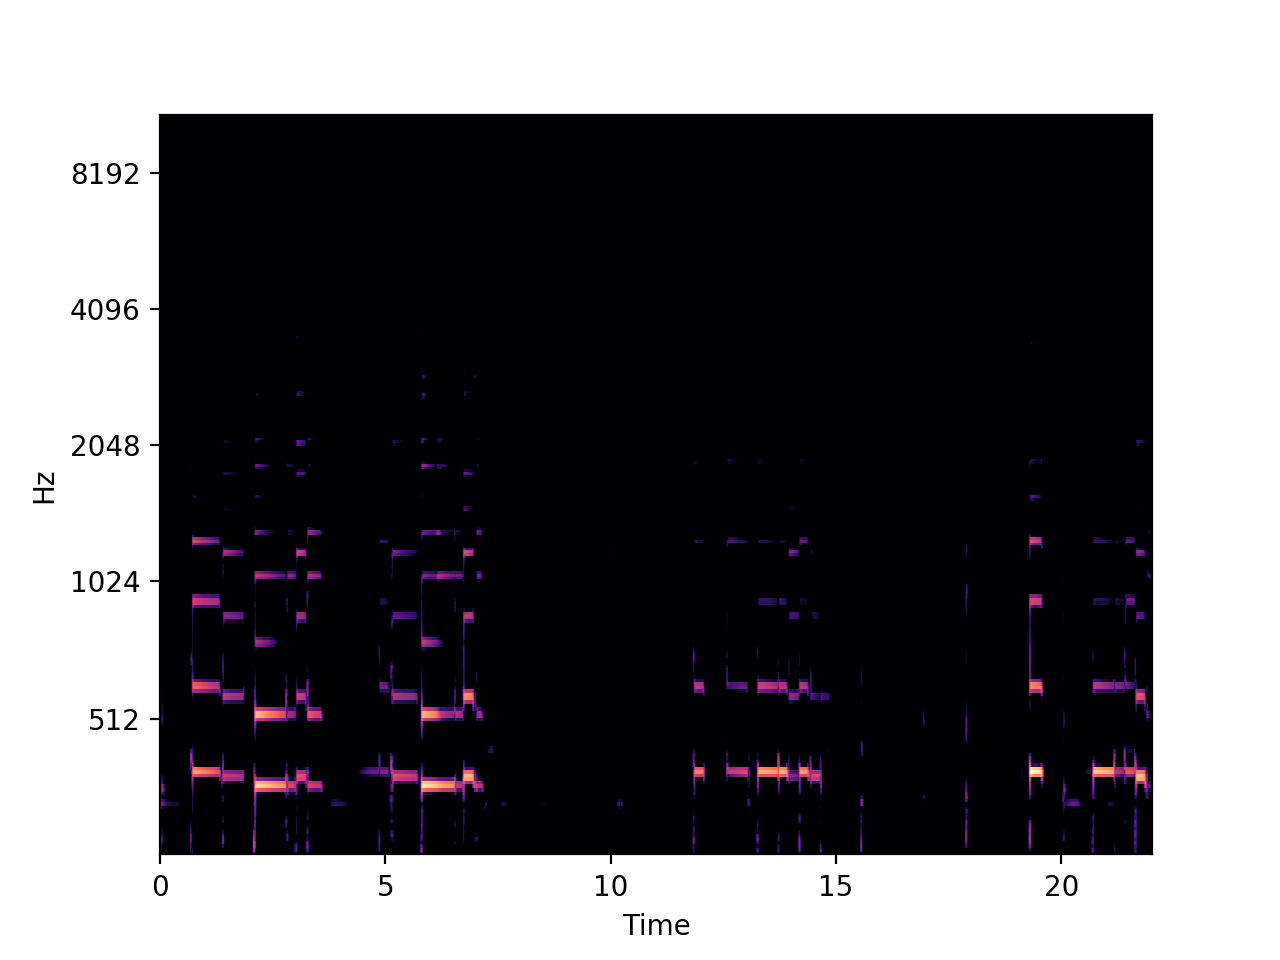

In [5]:
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='mel', x_axis='time')

In [15]:
@numba.jit
def ac_to_lagdelta(A, hop_length=512):
    
    m, n = A.shape
    
    Apad = np.pad(A, [(0, 0), (0, m)], mode='edge')
    
    D = -2 * Apad + Apad[0, :]
    
    # Instead of dividing by hop length, use linear interpolation
    for t in range(m):
        D[t, :-t] += Apad[0, t//hop_length:]
        
    return D[:, :n]

In [16]:
@numba.jit
def ac_to_lagcos(A, hop_length=512):
    
    m, n = A.shape
    
    Apad = np.pad(A, [(0, 0), (0, m)], mode='edge')
    
    Asqrt = np.sqrt(Apad[0])
    
    C = Apad / Asqrt
    
    for t in range(m):
        C[t, :-t] /= Asqrt[t//hop_length:]
        
    return C[:, :n]

In [10]:
@numba.jit
def yindist(y, hop_length=512, frame_length=2048):
    
    n_frames = 1 + int((len(y) - frame_length) / hop_length)
    D = np.zeros((frame_length, n_frames))
    
    for frame in range(n_frames):
        for t in range(frame_length):
            for j in range(frame_length):
                if frame * hop_length + t + j < len(y):
                    D[t, frame] += (y[frame * hop_length + j] - y[frame * hop_length + t + j])**2
    return D

In [11]:
# 1. frame and autocorrelate

fmin = librosa.note_to_hz('C1')

max_lag = librosa.time_to_samples(1./fmin, sr=sr)

yf = librosa.util.frame(y, frame_length=max_lag[0])
A = librosa.autocorrelate(yf, axis=0)

In [394]:
#D = ac_to_lagdelta(A)

In [23]:
D = yindist(y, frame_length=max_lag[0])

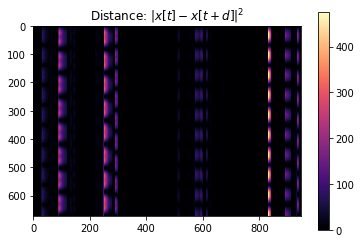

In [44]:
plt.imshow(D, cmap='magma')
plt.title(r'Distance: $|x[t] - x[t+d]|^2$')
plt.colorbar()
plt.show()

In [14]:
sigsq = np.mean(D)

In [15]:
P = np.exp(-0.5 * D/sigsq)
P = librosa.util.normalize(P, axis=0, norm=1)

In [16]:
#C = ac_to_lagcos(A)
#C = A / A[0]
C = librosa.util.normalize(A, axis=0, norm=np.inf, threshold=1e-6)

In [17]:
C = np.clip(C, 0, None)

In [18]:
sigsq2 = np.mean(np.abs(C))
P2 = np.exp(0.5 * C / sigsq2)
P2 = librosa.util.normalize(P2, axis=0, norm=1)

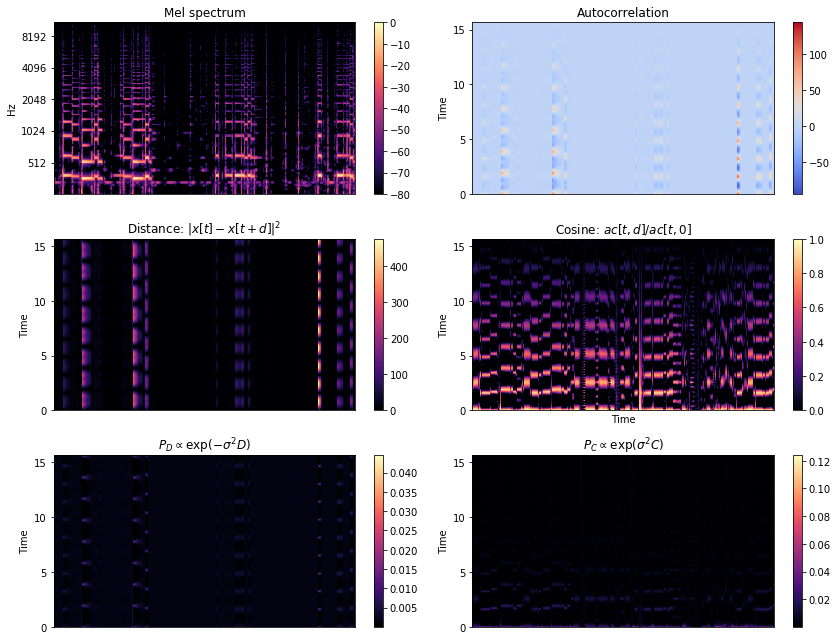

In [21]:
plt.figure(figsize=(12, 9))
plt.subplot(3,2,1)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel')
plt.colorbar()
plt.title('Mel spectrum')

ax = plt.subplot(3,2,2)
librosa.display.specshow(A, x_axis='time', y_axis='time')
plt.xlabel('')
plt.xticks([])
plt.title('Autocorrelation')
plt.colorbar()

plt.subplot(3,2,3, sharex=ax, sharey=ax)
librosa.display.specshow(D, x_axis='time', y_axis='time')
plt.title(r'Distance: $|x[t] - x[t+d]|^2$')
plt.xlabel('')
plt.xticks([])
plt.colorbar()
plt.subplot(3,2,4, sharex=ax, sharey=ax)
librosa.display.specshow(C, x_axis='time', y_axis='time')
plt.title(r'Cosine: $ac[t, d] / ac[t,0]$')
plt.colorbar()

plt.subplot(3,2,5, sharex=ax, sharey=ax)
librosa.display.specshow(P, x_axis='time', y_axis='time')
plt.title(r'$P_D \propto \exp(-\sigma^2 D)$')
plt.xlabel('')
plt.xticks([])
plt.colorbar()

plt.subplot(3,2,6, sharex=ax, sharey=ax)
librosa.display.specshow(P2, x_axis='time', y_axis='time')
plt.title(r'$P_C \propto \exp(\sigma^2 C)$')
plt.xlabel('')
plt.xticks([])
plt.colorbar()
plt.tight_layout()

In [67]:

str_i = 3
str_midi_dict = {0: 40, 1: 45, 2: 50, 3: 55, 4: 59, 5: 64}
midi_range = [str_midi_dict[str_i]-0.5, str_midi_dict[str_i]+24]

hz_range = librosa.core.midi_to_hz(midi_range)
lag_range = np.round(1 / hz_range * sr).astype(int)
lag_range.sort()

In [68]:
lag_range

array([ 28, 116])

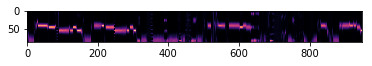

In [69]:
plt.imshow(P2[lag_range[0] : lag_range[1]], cmap='magma')